## **Prophet + Associated Net for Open, High and Low**

##**Preparing Environment**

In [ ]:
!pip install yfinance --upgrade --no-cache-dir
!pip install plotly==4.13.0

Requirement already up-to-date: yfinance in /usr/local/lib/python3.6/dist-packages (0.1.55)


In [ ]:
#Importing Libraries
from fbprophet import Prophet
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, Dropout, Input, Lambda, concatenate
from sklearn.metrics import mean_absolute_error
import pandas as pd
import plotly.graph_objects as go
tf.__version__

'2.4.0'

##**Importing data from yfinance**

In [ ]:
yf.pdr_override()
df = pdr.get_data_yahoo("0763.HK", start="2010-01-01", end="2021-01-01")
df = df[['Open','Low','High']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.head()

,Open,Low,High
Date,,,
2010-01-04,21.550900,21.5509,24.328699
2010-01-05,23.981501,23.8426,24.768499
2010-01-06,24.629601,23.7269,24.629601
2010-01-07,24.444401,23.0093,24.444401
2010-01-08,24.050900,23.4722,24.074100


##**History of Stock Price**

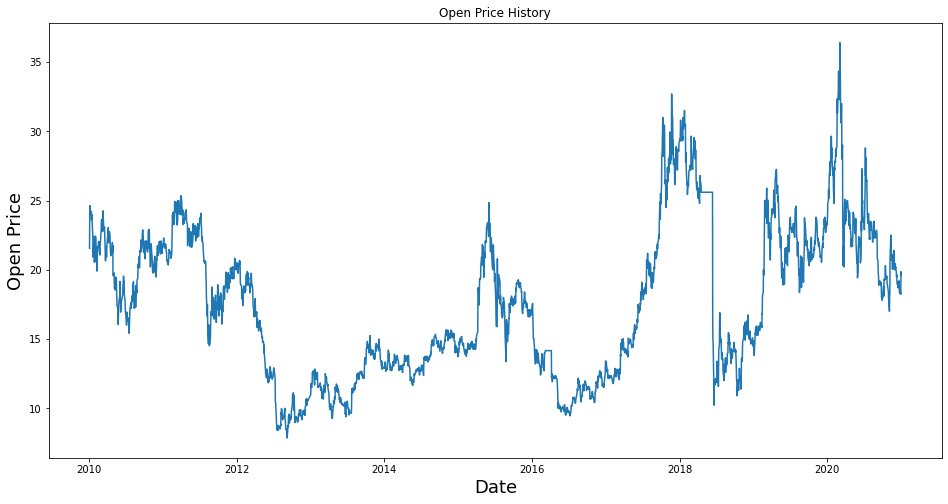

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Open Price History')
plt.plot(df[['Open']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price', fontsize=18)
plt.show()

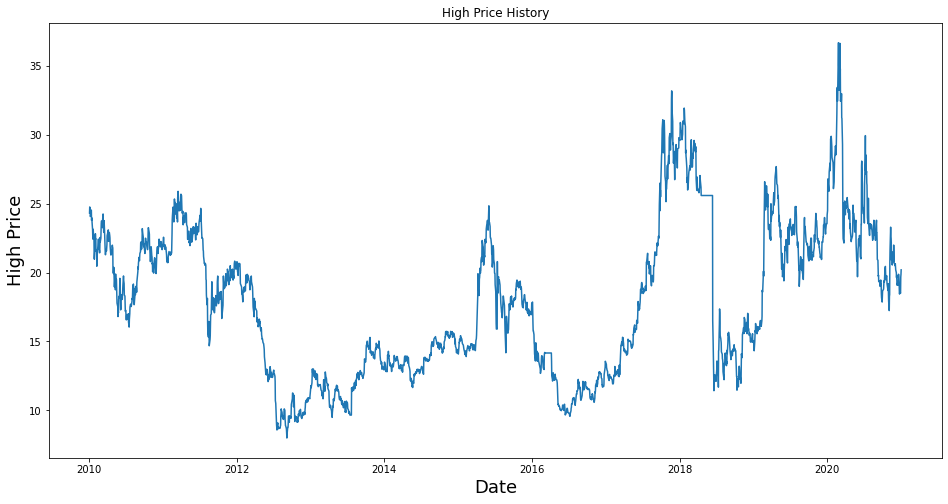

In [ ]:
plt.figure(figsize=(16,8))
plt.title('High Price History')
plt.plot(df[['High']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('High Price', fontsize=18)
plt.show()

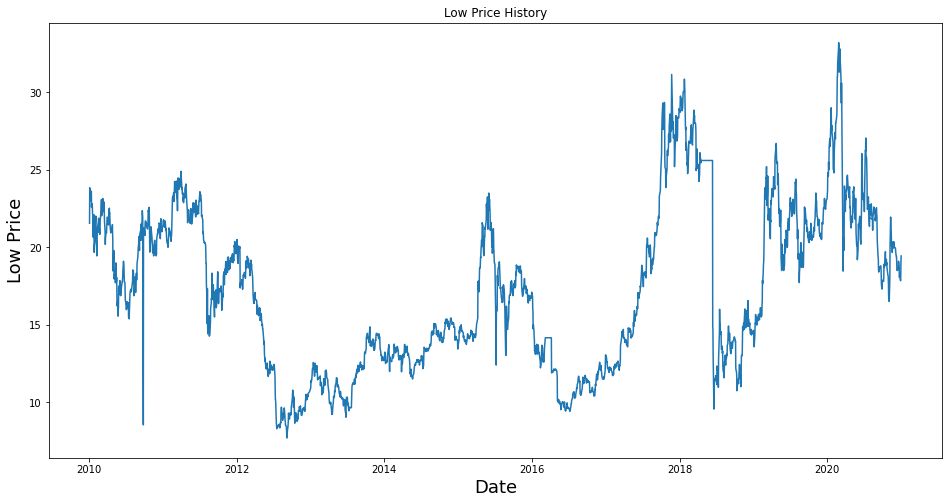

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Low Price History')
plt.plot(df[['Low']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Low Price', fontsize=18)
plt.show()

##Obtaining Forecast from Prophet

In [ ]:
prediction_period = 100

In [ ]:
#preparing dataframes for prophet
prophet_open, prophet_low, prophet_high = pd.DataFrame(),pd.DataFrame(),pd.DataFrame()
prophet_open['y'] = df['Open'].copy()
prophet_low['y'] = df['Low'].copy()
prophet_high['y'] = df['High'].copy()
prophet_open['ds'] = df.index
prophet_low['ds'] = df.index
prophet_high['ds'] = df.index


In [ ]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_open)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future_df = prophet.make_future_dataframe(periods=prediction_period)
open_predictions = prophet.predict(future_df)

prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_low)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future_df = prophet.make_future_dataframe(periods=prediction_period)
low_predictions = prophet.predict(future_df)

prophet = Prophet(daily_seasonality=True)
prophet.fit(prophet_high)  # df is a pandas.DataFrame with 'y' and 'ds' columns
future_df = prophet.make_future_dataframe(periods=prediction_period)
high_predictions = prophet.predict(future_df)


In [ ]:
prophet_df = pd.DataFrame()
prophet_df['Open'] = open_predictions['yhat'].copy()
prophet_df['Low'] = low_predictions['yhat'].copy()
prophet_df['High'] = high_predictions['yhat'].copy()
prophet_df.index = open_predictions['ds']
prophet_df.tail()

,Open,Low,High
ds,,,
2021-04-06,26.556973,25.850360,27.162888
2021-04-07,26.583696,25.896264,27.187055
2021-04-08,26.640085,25.929528,27.236637
2021-04-09,26.642852,25.941442,27.212871
2021-04-10,26.848872,26.213110,27.753291


##**Preparing Dataset for Training**

##**Scaling Data**

In [ ]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)
scaled_prophet_data = scaler.transform(prophet_df)
print(scaled_data.shape,scaled_prophet_data.shape)

(2709, 3) (2809, 3)


In [ ]:
#window size
WINDOW_SIZE = 20
TRAINING_DATA_LEN = int(scaled_data.shape[0]*0.75)

In [ ]:
#Create the scaled training data set
train_data = scaled_data[0:int(TRAINING_DATA_LEN), :]
 
#Split the data into x and y data sets
x = []
y = []
 
for i in range(WINDOW_SIZE, len(scaled_data)):
    x.append( scaled_prophet_data[i-WINDOW_SIZE:i,:3] ) #input from prophet predictions
    y.append( scaled_data[i,:3] ) #output from original dataset
 
x_train = x[:TRAINING_DATA_LEN]
y_train = y[:TRAINING_DATA_LEN]
x_test = x[TRAINING_DATA_LEN:]
y_test = y[TRAINING_DATA_LEN:]
 
x_train,y_train = shuffle(x_train,y_train)
 
x_train, y_train, x_test, y_test = np.array(x_train),np.array(y_train),np.array(x_test),np.array(y_test)
 
print('scaled_data shape:', scaled_data.shape,'\nx_train shape:',x_train.shape,'\ny_train shape:',y_train.shape,'\nx_test shape:',x_test.shape,'\ny_test shape:',y_test.shape)

scaled_data shape: (2709, 3) 
x_train shape: (2031, 20, 3) 
y_train shape: (2031, 3) 
x_test shape: (658, 20, 3) 
y_test shape: (658, 3)


##**Model Architecture**

In [ ]:
tf.compat.v1.reset_default_graph()

input_layer = Input(shape=(WINDOW_SIZE,3),ragged=True)

lstm11 = LSTM(10,return_sequences=True)(input_layer)
dropout11 = Dropout(0.7)(lstm11)
lstm12 = LSTM(10,return_sequences=False)(dropout11)
dropout12 = Dropout(0.7)(lstm12)
#dense1 = Dense(3,activation='relu')(dropout12)
output1 = Dense(1,activation='sigmoid')(dropout12)
model1 = Model(inputs=input_layer, outputs=output1)

lstm21 = LSTM(10,return_sequences=True)(input_layer)
expanded_output1 = tf.expand_dims(tf.matmul(model1.output,tf.ones([1,WINDOW_SIZE])),axis=-1)
inputs_2 = tf.concat([lstm21,expanded_output1],axis=2)
lstm22 = LSTM(10,return_sequences=True)(inputs_2)
dropout21 = Dropout(0.7)(lstm22)
lstm23 = LSTM(10,return_sequences=False)(dropout21)
dropout22 = Dropout(0.7)(lstm23)
output2 = Dense(1,activation='sigmoid')(dropout22)
model2 = Model(inputs=input_layer,outputs=output2)

lstm31 = LSTM(10,return_sequences=True)(input_layer)
expanded_output2 = tf.expand_dims(tf.matmul(model2.output,tf.ones([1,WINDOW_SIZE])),axis=-1)
inputs_3 = tf.concat([lstm31,expanded_output1,expanded_output2],axis=2)
lstm32 = LSTM(10,return_sequences=True)(inputs_3)
dropout31 = Dropout(0.7)(lstm32)
lstm33 = LSTM(10,return_sequences=False)(dropout31)
dropout32 = Dropout(0.7)(lstm33)
output3 = Dense(1,activation='sigmoid')(dropout32)
model3 = Model(inputs=input_layer,outputs=output3)

final_output = tf.concat([model1.output,model2.output,model3.output],axis=-1)

associated_net = Model(inputs=input_layer,outputs=final_output)
associated_net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 20, 3)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 20, 10)       560         input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 20, 10)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 10)           840         dropout[0][0]                    
____________________________________________________________________________________________

In [ ]:
associated_net.compile(optimizer="adam", loss="mse", metrics=["mse"])
history = associated_net.fit(x_train, y_train, epochs=100,batch_size=64, validation_data=(x_test,y_test))

Epoch 1/100
32/32 [==============================] - 11s 86ms/step - loss: 0.0687 - mse: 0.0687 - val_loss: 0.0388 - val_mse: 0.0388
Epoch 2/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0479 - mse: 0.0479 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 3/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0321 - mse: 0.0321 - val_loss: 0.0283 - val_mse: 0.0283
Epoch 4/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0228 - val_mse: 0.0228
Epoch 5/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 6/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 7/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0242 - val_mse: 0.0242
Epoch 8/100
32/32 [==============================] - 1s 22ms/step - loss: 0

In [ ]:
p_train = associated_net.predict(x_train)

an_train_open_mae = mean_absolute_error(y_train[:,0],p_train[:,0])
an_train_open_acc = 1-an_train_open_mae
print('Open loss(MAE): ',an_train_open_mae)
print('Open Accuracy(1-MAE): ',an_train_open_acc)


an_train_high_mae = mean_absolute_error(y_train[:,2],p_train[:,2])
an_train_high_acc = 1-an_train_high_mae
print('High loss(MAE): ',an_train_high_mae)
print('High Accuracy(1-MAE): ',an_train_high_acc)


an_train_low_mae = mean_absolute_error(y_train[:,1],p_train[:,1])
an_train_low_acc = 1-an_train_low_mae
print('Close loss(MAE): ',an_train_low_mae)
print('Close Accuracy(1-MAE): ',an_train_low_acc)

print('Average Accuracy: ', (an_train_open_acc+an_train_high_acc+an_train_low_acc)/3)

Open loss(MAE):  0.05277526791390126
Open Accuracy(1-MAE):  0.9472247320860987
High loss(MAE):  0.052733048183302884
High Accuracy(1-MAE):  0.9472669518166971
Close loss(MAE):  0.05786104934908728
Close Accuracy(1-MAE):  0.9421389506509127
Average Accuracy:  0.945543544851236


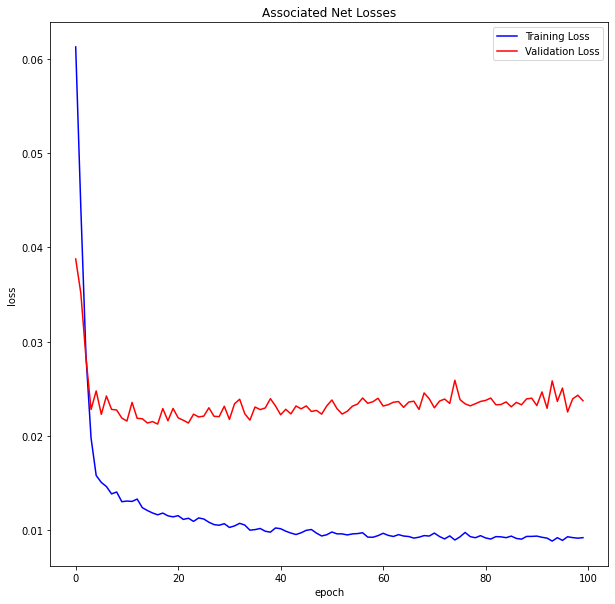

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'],'b')
plt.plot(history.history['val_loss'],'r')
plt.title('Associated Net Losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

##**Predicting on Test Data**

In [ ]:
p_test = associated_net.predict(x_test)

an_test_open_mae = mean_absolute_error(y_test[:,0],p_test[:,0])
an_test_open_acc = 1-an_test_open_mae
print('Open loss(MAE): ',an_test_open_mae)
print('Open Accuracy(1-MAE): ',an_test_open_acc)


an_test_high_mae = mean_absolute_error(y_test[:,2],p_test[:,2])
an_test_high_acc = 1-an_test_high_mae
print('High loss(MAE): ',an_test_high_mae)
print('High Accuracy(1-MAE): ',an_test_high_acc)


an_test_low_mae = mean_absolute_error(y_test[:,1],p_test[:,1])
an_test_low_acc = 1-an_test_low_mae
print('Close loss(MAE): ',an_test_low_mae)
print('Close Accuracy(1-MAE): ',an_test_low_acc)

an_avg = (an_test_open_acc+an_test_high_acc+an_test_low_acc)/3

print('Average Accuracy: ', an_avg)

Open loss(MAE):  0.11455186479505712
Open Accuracy(1-MAE):  0.8854481352049429
High loss(MAE):  0.12443834163773734
High Accuracy(1-MAE):  0.8755616583622626
Close loss(MAE):  0.14166119312846498
Close Accuracy(1-MAE):  0.858338806871535
Average Accuracy:  0.8731162001462468


In [ ]:
#Rescaling
ptemp = np.concatenate([p_test,scaled_data[TRAINING_DATA_LEN+WINDOW_SIZE:,3:]],axis=1)
ytemp = np.concatenate([y_test,scaled_data[TRAINING_DATA_LEN+WINDOW_SIZE:,3:]],axis=1)
p_rescaled = scaler.inverse_transform(ptemp)
y_rescaled = scaler.inverse_transform(ytemp)

In [ ]:
p_rescaled.shape

(658, 3)

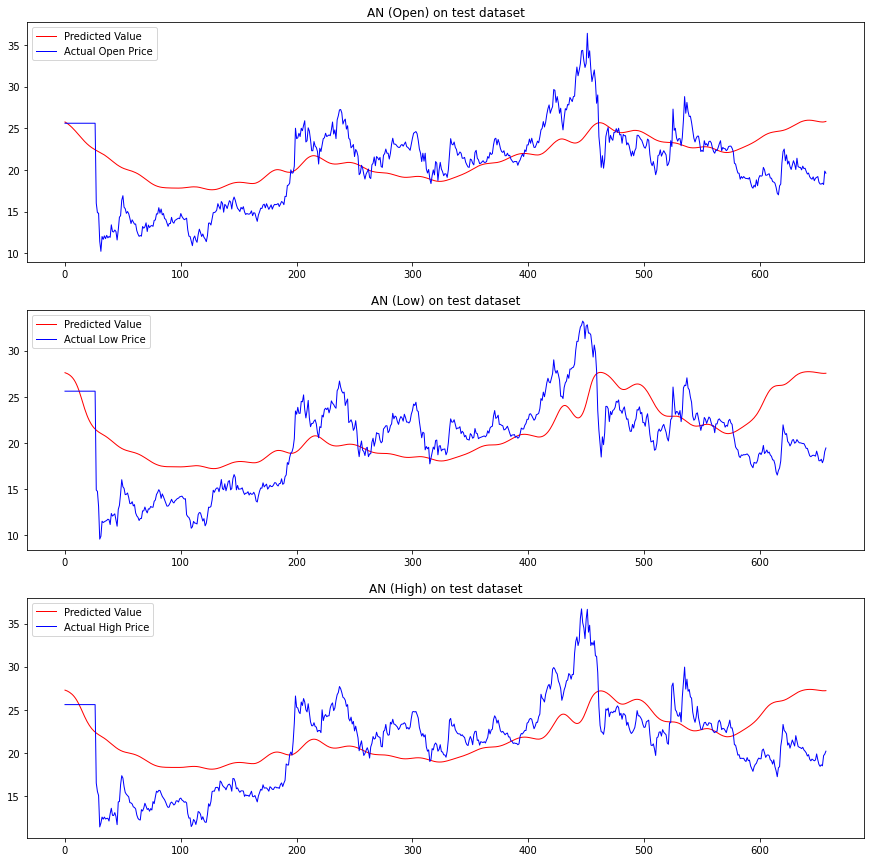

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(311)
plt.plot(p_rescaled[:,0],'r',linewidth=1)
plt.plot(y_rescaled[:,0],'b',linewidth=1)
plt.title('AN (Open) on test dataset')
plt.legend(['Predicted Value', 'Actual Open Price'], loc='upper left')
plt.subplot(312)
plt.plot(p_rescaled[:,1],'r',linewidth=1)
plt.plot(y_rescaled[:,1],'b',linewidth=1)
plt.title('AN (Low) on test dataset')
plt.legend(['Predicted Value', 'Actual Low Price'], loc='upper left')
plt.subplot(313)
plt.plot(p_rescaled[:,2],'r',linewidth=1)
plt.plot(y_rescaled[:,2],'b',linewidth=1)
plt.title('AN (High) on test dataset')
plt.legend(['Predicted Value', 'Actual High Price'], loc='upper left')
plt.show()

##**Forecasting with Associated Net**

In [ ]:
PRED_DAYS = 100

In [ ]:
x_pred=[]
for i in range(WINDOW_SIZE, len(scaled_prophet_data)):
    x_pred.append( scaled_prophet_data[i-WINDOW_SIZE:i,:] ) #input from prophet predictions
x_pred = np.array(x_pred)
y_pred = associated_net.predict(x_pred)
print(len(x_pred),len(y_pred))


2789 2789


In [ ]:
#Rescaling
dt_index = open_predictions['ds'][WINDOW_SIZE:]
p_rescaled = scaler.inverse_transform(y_pred)
y_rescaled = scaler.inverse_transform(y)
len(dt_index)

2789

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = dt_index,y=p_rescaled[:,0],
                      name='predicted_open',
                      marker=dict(size=1),
                      line = dict(color='red',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=p_rescaled[:,1],
                      name='predicted_low',
                      marker=dict(size=1),
                      line = dict(color='red',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=p_rescaled[:,2],
                      name='predicted_high',
                      marker=dict(size=1),
                      line = dict(color='red',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=y_rescaled[:,0],
                      name='actual_open',
                      marker=dict(size=1),
                      line = dict(color='blue',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=y_rescaled[:,1],
                      name='actual_low',
                      marker=dict(size=1),
                      line = dict(color='blue',width=1)
                      #mode="markers",
                  ))

fig.add_trace(go.Scatter(x=dt_index, y=y_rescaled[:,2],
                      name='actual_high',
                      marker=dict(size=1),
                      line = dict(color='blue',width=1)
                      #mode="markers",
                  ))



fig.add_vline(x='2021-01-01', line_width=3, line_dash="dash", line_color="green", name='current date')
'''
fig.update_layout(
    title='Shanghai Index',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
'''
fig.write_html('sample.html')
fig.show()